In [1]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
%matplotlib inline

In [15]:
def cold_cache(parts):
    remove = ["cache=cold", "cache=hot"]
    result = None
    if "cache=cold" in parts:
        result = True
    else:
        result = False
    parts = filter(lambda v: v not in remove, parts)
    return result, parts
    
def uses(parts):
    remove = ["--use-cls", "--use-index"]
    uses_cls = "--use-cls" in parts
    uses_idx = "--use-index" in parts
    parts = filter(lambda v: v not in remove, parts)
    return uses_cls, uses_idx, parts    
    
def process_line(line):
    ignore = ["/usr/bin/run-query", "--quiet", "run-1", "run-2", "run-3", "run-4"]
    if line[:18] != "/usr/bin/run-query":
        return None
    parts = line.split()
    parts = filter(lambda v: v not in ignore, parts)
    # runtime
    runtime = float(parts[-1])
    parts = parts[:-1]
    # use cls
    uses_cls, uses_idx, parts = uses(parts)
    is_cold_cache, parts = cold_cache(parts)
    # convert to key/value pairs
    assert len(parts) % 2 == 0
    res = {'runtime': runtime, 'cls': uses_cls, 'idx': uses_idx, 'coldcache': is_cold_cache}
    pit = iter(parts)
    for key in pit:
        assert key[:2] == "--"
        key = key[2:]
        val = next(pit)
        try:
            val = float(val)
        except:
            pass
        res.update({key:val})
    return res

def load_traces(fnpat):
    for fn in glob.glob(fnpat):
        print fn, fnpat
        with open(fn, 'r') as f:
            results = filter(None, map(process_line, f.readlines()))
            return pd.DataFrame(results)

def combine_traces(*fns):
    fnit = iter(fns)
    dfs = []
    for fn in fnit:
        df = load_traces(fn)
        df["nosds"] = next(fnit)
        df["nobjs"] = next(fnit)
        dfs.append(df)
    return pd.concat(dfs)

df = combine_traces("dev-partitioned-4osd.log", 4, 10000, "dev-partition-4osds-7500objs.log", \
                    4, 7500, "dev-partition-4osds-5000objs.log", 4, 5000)
del df['extended-price']
del df['num-objs']
del df['pool']
del df['query'] # only b
del df['idx']
df = df[df.nthreads == 20.0]
df = df.groupby(['cls', 'nosds', 'nthreads', 'coldcache', 'nobjs']).mean().reset_index()
df

dev-partitioned-4osd.log dev-partitioned-4osd.log
dev-partition-4osds-7500objs.log dev-partition-4osds-7500objs.log
dev-partition-4osds-5000objs.log dev-partition-4osds-5000objs.log


,cls,nosds,nthreads,coldcache,nobjs,runtime
0,False,4,20.0,False,5000,60.309709
1,False,4,20.0,False,7500,91.076028
2,False,4,20.0,False,10000,245.344653
3,False,4,20.0,True,5000,139.324916
4,False,4,20.0,True,7500,208.873897
5,False,4,20.0,True,10000,283.948599
6,True,4,20.0,False,5000,7.179493
7,True,4,20.0,False,7500,12.650408
8,True,4,20.0,False,10000,83.852776
9,True,4,20.0,True,5000,139.519023


     cls  nobjs     runtime
0  False   5000   60.309709
1  False   7500   91.076028
2  False  10000  245.344653
6   True   5000    7.179493
7   True   7500   12.650408
8   True  10000   83.852776


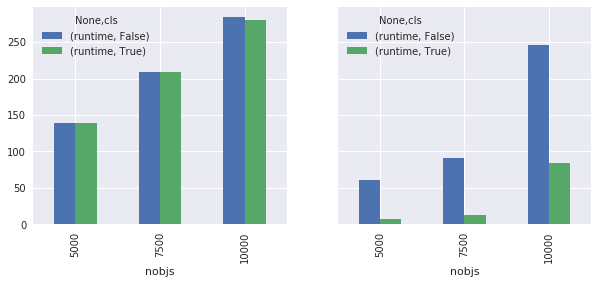

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4))

print df2

df2 = df[df.coldcache == True]
del df2["nthreads"]
del df2["coldcache"]
del df2["nosds"]
df2.set_index(["cls", "nobjs"]).unstack(0).plot.bar(ax=ax[0])

df2 = df[df.coldcache == False]
del df2["nthreads"]
del df2["coldcache"]
del df2["nosds"]
df2.set_index(["cls", "nobjs"]).unstack(0).plot.bar(ax=ax[1])